In [ ]:
#Retinal Disease Classification

#Dataset: https://www.kaggle.com/datasets/andrewmvd/retinal-disease-classification
#Build a model that classifies between healthy and unhealthy retinas
#Build a model that further identifies the disease(s) amongst the images with unhealthy retinas

In [1]:
#Download dataset from kaggle
import kagglehub

# Download latest version
path = kagglehub.dataset_download("andrewmvd/retinal-disease-classification")

print("Path to dataset files:", path)

100%|██████████| 7.43G/7.43G [11:55<00:00, 11.1MB/s]  

Extracting files...


Path to dataset files: C:\Users\rantr\.cache\kagglehub\datasets\andrewmvd\retinal-disease-classification\versions\1


In [2]:
#import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
from sklearn.model_selection import train_test_split
from sklearn import metrics
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping
from keras.regularizers import l2
from keras.utils import to_categorical
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import InceptionV3
#from keras.applications.inception_resnet_v2 import InceptionResNetV2


In [3]:
#Paths to Dataset

train_dir = path+ '/Training_Set/Training_Set/Training/'
test_dir = path+ '/Test_Set/Test_Set/Test/'
validation_dir = path+ '/Evaluation_Set/Evaluation_Set/Validation/'

train_labels = path+ '/Training_Set/Training_Set/RFMiD_Training_Labels.csv'
test_labels = path+ '/Test_Set/Test_Set/RFMiD_Testing_Labels.csv'
validation_labels = path+ '/Evaluation_Set/Evaluation_Set/RFMiD_Validation_Labels.csv'


In [4]:
#Load the labels
train_df = pd.read_csv(train_labels)
test_df = pd.read_csv(test_labels)
validation_df = pd.read_csv(validation_labels)

In [5]:
train_df.head()

,ID,Disease_Risk,DR,ARMD,MH,DN,MYA,BRVO,TSLN,ERM,...,CME,PTCR,CF,VH,MCA,VS,BRAO,PLQ,HPED,CL
0,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<Axes: xlabel='None'>

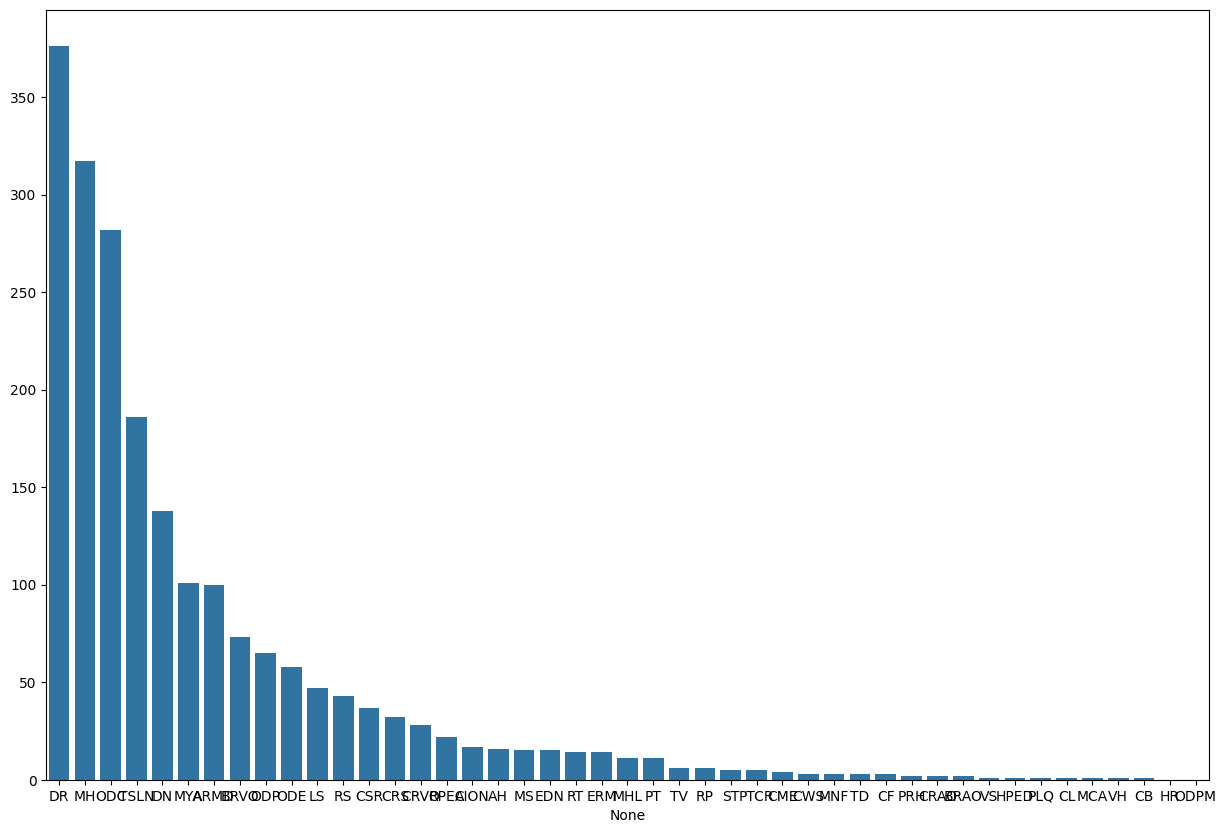

In [6]:
#Expolartory Data Analysis
diseases = train_df.iloc[:, 2:].sum().sort_values(ascending=False)
plt.figure(figsize=(15,10))
sns.barplot(x=diseases.index, y=diseases.values)


In [ ]:
diseases

,0
DR,376
MH,317
ODC,282
TSLN,186
DN,138
MYA,101
ARMD,100
BRVO,73
ODP,65
ODE,58


In [ ]:
num_classes = diseases.count()
print("Number of classes:", num_classes)

Number of classes: 45


In [7]:
#Data preprocessing

def processData(image_dir, labels_df):
    images = []
    labels = []
    for index, row in labels_df.iterrows():
        img_path = os.path.join(image_dir, f"{row['ID']}.png")
        if os.path.exists(img_path):
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (128, 128))
            images.append(img)
            labels.append(row['Disease_Risk'])
    return np.array(images), np.array(labels)



In [8]:
X_train, y_train = processData(train_dir, train_df)
X_val, y_val = processData(validation_dir, validation_df)
X_test, y_test = processData(test_dir, test_df)

In [ ]:
#Convert 1-dimensional class arrays to 30-dimensional class matrices for labels[breed]
def convert2ndim(labels, n):
  Y= to_categorical(labels, n)
  return Y


In [ ]:
Y_train = convert2ndim(y_train, 2)
Y_val = convert2ndim(y_val, 2)
Y_test = convert2ndim(y_test, 2)

In [9]:
Y_train,Y_val,Y_test = y_train,y_val,y_test

In [10]:
print(X_train.shape, Y_train.shape)
print(X_val.shape, Y_val.shape)
print(X_test.shape, Y_test.shape)

(1920, 128, 128, 3) (1920,)
(640, 128, 128, 3) (640,)
(640, 128, 128, 3) (640,)


In [11]:
#Normalize the images by dividing each pixel by 255 and apply data augmentation to the training data

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   #featurewise_center=True,
                                    #featurewise_std_normalization=True,
                                    rotation_range=20,
                                    #width_shift_range=0.2,
                                    #height_shift_range=0.2,
                                    horizontal_flip=True
                                    )
val_datagen = ImageDataGenerator(rescale = 1./255,
                                    )
test_datagen = ImageDataGenerator(rescale = 1./255,)

In [12]:
train_datagen.fit(X_train)
val_datagen.fit(X_val)
test_datagen.fit(X_test)

In [13]:
training_set =  train_datagen.flow(X_train,Y_train, batch_size = 8)
validation_set = val_datagen.flow(X_val,Y_val, batch_size = 8)
testing_set  =  test_datagen.flow(X_test,Y_test, batch_size = 8)


In [14]:
def getModel(pretrained, input_shape):

    pretrained_model = pretrained(include_top=False, input_shape=input_shape,weights='imagenet')
    #Make model not trainable for use in feature extraction
    for layer in pretrained_model.layers:
        layer.trainable = False
    #Get last layer
    last_output = pretrained_model.layers[-1].output
    # Flatten the output layer to 1 dimension
    res = Flatten()(last_output)
    # Add a fully connected layer with 128 hidden units and ReLU activation
    #res = Dense(1024,activation="relu")(res)
    #res = Dropout(0.2)(res)
    res = Dense(256,activation="relu")(res)
    res = Dropout(0.5)(res)
    res = BatchNormalization()(res)
    res = Dense(1,activation="sigmoid")(res)

    # Configure and compile the model
    model = Model(pretrained_model.input, res)
    model.compile(loss='binary_crossentropy',
                optimizer=RMSprop(learning_rate = 0.0001),
                metrics=['AUC', 'acc'])
    model.summary()
    return model

In [15]:
EarlyStop = EarlyStopping(monitor='val_loss', mode= 'min',patience=10, verbose=1)

In [16]:
#Train the model
input_shape = (128,128,3)
model = getModel(InceptionV3, input_shape)
#Fit the model
history = model.fit(training_set,epochs = 30, validation_data = validation_set, verbose =1, callbacks = [EarlyStop])


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 63, 63,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 63, 63,    │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 63, 63,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 61, 61,    │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 61, 61,    │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 61, 61,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 61, 61,    │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 61, 61,    │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 61, 61,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 30, 30,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 30, 30,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 30, 30,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 30, 30,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 28, 28,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 28, 28,    │          0 │ batch_normalizat

 Total params: 23,901,473 (91.18 MB)

 Trainable params: 2,098,177 (8.00 MB)

 Non-trainable params: 21,803,296 (83.17 MB)

c:\Users\rantr\blue\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
240/240 ━━━━━━━━━━━━━━━━━━━━ 36s 117ms/step - AUC: 0.6859 - acc: 0.6169 - loss: 0.7110 - val_AUC: 0.8584 - val_acc: 0.8219 - val_loss: 0.3852
Epoch 2/30
240/240 ━━━━━━━━━━━━━━━━━━━━ 30s 124ms/step - AUC: 0.8012 - acc: 0.7389 - loss: 0.5234 - val_AUC: 0.8472 - val_acc: 0.8359 - val_loss: 0.3966
Epoch 3/30
240/240 ━━━━━━━━━━━━━━━━━━━━ 29s 121ms/step - AUC: 0.7859 - acc: 0.7691 - loss: 0.4781 - val_AUC: 0.8757 - val_acc: 0.8406 - val_loss: 0.3784
Epoch 4/30
240/240 ━━━━━━━━━━━━━━━━━━━━ 31s 129ms/step - AUC: 0.8234 - acc: 0.8212 - loss: 0.3973 - val_AUC: 0.8752 - val_acc: 0.8234 - val_loss: 0.4128
Epoch 5/30
240/240 ━━━━━━━━━━━━━━━━━━━━ 31s 130ms/step - AUC: 0.8449 - acc: 0.8482 - loss: 0.3721 - val_AUC: 0.8666 - val_acc: 0.8328 - val_loss: 0.3601
Epoch 6/30
240/240 ━━━━━━━━━━━━━━━━━━━━ 30s 127ms/step - AUC: 0.8489 - acc: 0.8408 - loss: 0.3688 - val_AUC: 0.8908 - val_acc: 0.8438 - val_loss: 0.3578
Epoch 7/30
240/240 ━━━━━━━━━━━━━━━━━━━━ 33s 136ms/step - AUC: 0.8265 - acc: 0.8248

In [ ]:
"""from sklearn.model_selection import KFold

kf = KFold(n_splits = 3, random_state = 7, shuffle = True)

#Combine the training and validation set into one evaluation set
X_eval = np.vstack((X_train, X_val))
Y_eval = np.vstack((Y_train, Y_val))

fold = 0

input_shape = (128,128,3)
modelk = getModel(InceptionV3, input_shape)

for train_index, val_index in kf.split(X_eval,Y_eval):
    fold += 1
    print("Results for fold",fold)

    X_train1, X_val = X_eval[train_index], X_eval[val_index]
    Y_train1, Y_val = Y_eval[train_index], Y_eval[val_index]


    #Start Image classification model
    train_datagen.fit(X_train1)
    val_datagen.fit(X_val)
    training_set = train_datagen.flow(X_train1, Y_train1, batch_size=15)

    validation_set = val_datagen.flow(X_val, Y_val, batch_size= 15)


    #Fit the model
    historyk = modelk.fit(training_set,epochs = 20, validation_data = validation_set, verbose =1)"""


'from sklearn.model_selection import KFold\n\nkf = KFold(n_splits = 3, random_state = 7, shuffle = True)\n\n#Combine the training and validation set into one evaluation set\nX_eval = np.vstack((X_train, X_val))\nY_eval = np.vstack((Y_train, Y_val))\n\nfold = 0\n\ninput_shape = (128,128,3)\nmodelk = getModel(InceptionV3, input_shape)\n\nfor train_index, val_index in kf.split(X_eval,Y_eval):\n    fold += 1\n    print("Results for fold",fold)\n\n    X_train1, X_val = X_eval[train_index], X_eval[val_index]\n    Y_train1, Y_val = Y_eval[train_index], Y_eval[val_index]\n\n\n    #Start Image classification model\n    train_datagen.fit(X_train1)\n    val_datagen.fit(X_val)\n    training_set = train_datagen.flow(X_train1, Y_train1, batch_size=15)\n\n    validation_set = val_datagen.flow(X_val, Y_val, batch_size= 15)\n\n\n    #Fit the model\n    historyk = modelk.fit(training_set,epochs = 20, validation_data = validation_set, verbose =1)'

In [17]:
model.evaluate(training_set,verbose=1)
model.evaluate(validation_set,verbose=1)

240/240 ━━━━━━━━━━━━━━━━━━━━ 18s 75ms/step - AUC: 0.9192 - acc: 0.8842 - loss: 0.2771
80/80 ━━━━━━━━━━━━━━━━━━━━ 8s 102ms/step - AUC: 0.9175 - acc: 0.8445 - loss: 0.3265


[0.352236807346344, 0.896554708480835, 0.8296874761581421]

In [18]:
model.save('retinal_model.keras')

Text(0.5, 1.0, 'Training and validation AUC')

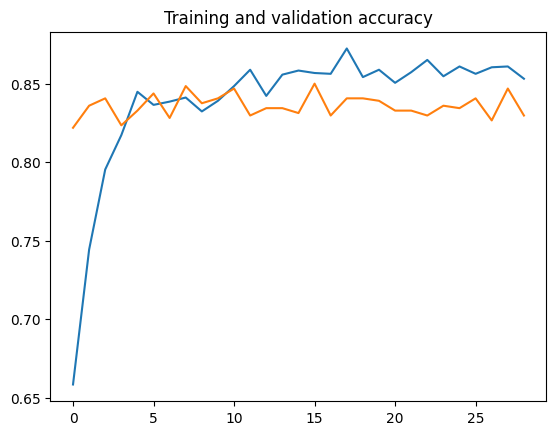

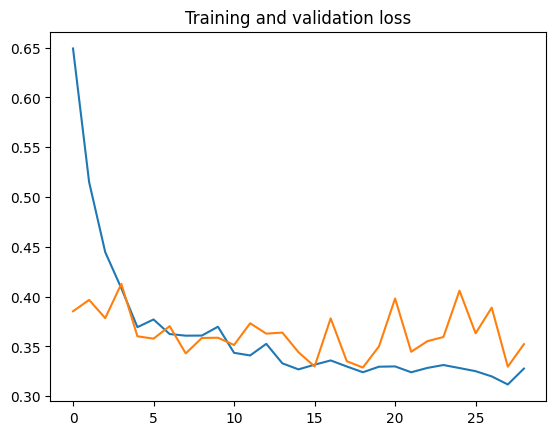

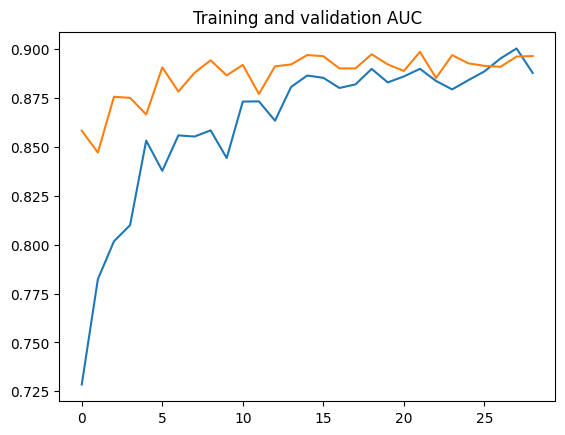

In [19]:
# Retrieve a list of accuracy results on training and validation data
# sets for each training epoch
acc = history.history['acc']
val_acc = history.history['val_acc']

# Retrieve a list of loss results on training and validation data
# sets for each validation epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Retrieve a list of loss results on training and validation data
# sets for each validation epoch
auc = history.history['AUC']
val_auc = history.history['val_AUC']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')

plt.figure()

# Plot training and validation AUC per epoch
plt.plot(epochs, auc)
plt.plot(epochs, val_auc)
plt.title('Training and validation AUC')

In [21]:
#Test the model

predictions = model.predict(testing_set)

model.evaluate(testing_set, verbose=1)


80/80 ━━━━━━━━━━━━━━━━━━━━ 6s 75ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 7s 83ms/step - AUC: 0.9121 - acc: 0.8541 - loss: 0.3367


[0.3097609281539917, 0.92628014087677, 0.862500011920929]